## 1. Lecture CSV

In [1]:
import numpy as np
import pandas as pd
import plotly.express as px
from sklearn.metrics import classification_report, confusion_matrix
from transformers import pipeline

In [2]:
#df_spam = pd.read_csv("../datas/spam_clean.csv", encoding="iso-8859-1")
df_spam = pd.read_csv("/content/spam_clean.csv", encoding="iso-8859-1")
df_spam.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   label_text  5572 non-null   object
 1   message     5572 non-null   object
 2   label       5572 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 130.7+ KB


---

## 2. Modèle Zero-shot-classification

In [4]:
classifier = pipeline("zero-shot-classification", model="facebook/bart-large-mnli")
topics = df_spam["label_text"].unique() # ham et spam

pred = [classifier(x, topics) for x in df_spam["message"]]

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.15k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Device set to use cuda:0
You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


In [5]:
df_zero_shot = pd.DataFrame(pred)

# Extraction du label et du score ayant la valeur maximale
df_zero_shot["label"] = df_zero_shot.apply(lambda row: row["labels"][row["scores"].index(max(row["scores"]))], axis=1)
df_zero_shot["score"] = df_zero_shot.apply(lambda row: max(row["scores"]), axis=1)

# On garde uniquement les colonnes pertinentes
df_zero_shot = df_zero_shot[["sequence", "label", "score"]]

# Aperçu
df_zero_shot.head()

,sequence,label,score
0,"Go until jurong point, crazy.. Available only ...",ham,0.658293
1,Ok lar... Joking wif u oni...,spam,0.522033
2,Free entry in 2 a wkly comp to win FA Cup fina...,ham,0.665671
3,U dun say so early hor... U c already then say...,ham,0.503479
4,"Nah I don't think he goes to usf, he lives aro...",ham,0.553275


Classification report

In [6]:
print(classification_report(df_spam["label_text"], df_zero_shot["label"]))

              precision    recall  f1-score   support

         ham       0.87      0.73      0.80      4825
        spam       0.14      0.29      0.19       747

    accuracy                           0.67      5572
   macro avg       0.51      0.51      0.49      5572
weighted avg       0.77      0.67      0.72      5572



Matrice de confusion

In [ ]:
mat = confusion_matrix(df_spam["label_text"], df_zero_shot["label"])

labels = df_spam["label_text"].unique()
df_mat = pd.DataFrame(mat, index=labels, columns=labels)

px.imshow(df_mat, text_auto=True, color_continuous_scale=px.colors.sequential.Aggrnyl)

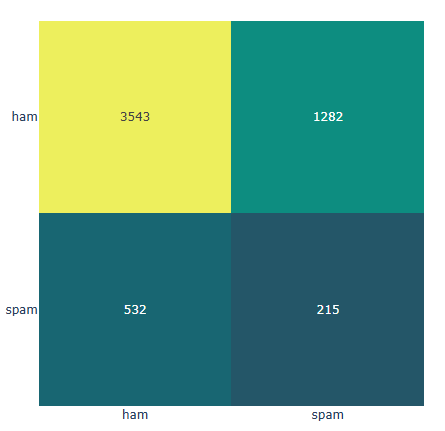

### Conclusion

Le modèle Zero-shot-classification n'est pas du tout adapté, toutes nos métriques sont fortement en baisse.

Il y a une forte augmentation des faux-positifs et des faux-négatifs.

---

## 3. Modèle spécifique entraîné pour reconnaître les spams mshenoda/roberta-spam

In [9]:
pipeline = pipeline("text-classification", model="mshenoda/roberta-spam")

config.json:   0%|          | 0.00/735 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.31k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/999k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/957 [00:00<?, ?B/s]

Device set to use cuda:0


In [10]:
from transformers import AutoTokenizer

# Load model directly
checkpoint = "mshenoda/roberta-spam"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

### Dataset and split datas

In [11]:
def tokenize_function(example):
    return tokenizer(example["message"], truncation=True, padding=True)

In [12]:
from datasets import Dataset

# Conversion pandas -> Hugging Face Dataset
hf_dataset = Dataset.from_pandas(df_spam)

# Split 80% train, 20% test (ou val)
split_dataset = hf_dataset.train_test_split(test_size=0.2)

# Accès aux sous-datasets
train_dataset = split_dataset["train"]
val_dataset = split_dataset["test"]

# Appliquer la fonction de tokenization avec batching
tokenized_train_dataset = train_dataset.map(tokenize_function, batched=True)
tokenized_val_dataset = val_dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/4457 [00:00<?, ? examples/s]

Map:   0%|          | 0/1115 [00:00<?, ? examples/s]

In [13]:
from transformers import DataCollatorWithPadding

# Auto Padding : toutes les séquences sont de la même longueur
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [14]:
# On vérifie la taille des séquences
samples = tokenized_train_dataset[:8]
samples = {k: v for k, v in samples.items() if k not in ["idx", "sentence1", "sentence2"]}
[len(x) for x in samples["input_ids"]]

[171, 171, 171, 171, 171, 171, 171, 171]

### FineTuning

In [15]:
from transformers import TrainingArguments

# paramètres d'entrainement par défaut
training_args = TrainingArguments("test-trainer", report_to="none")

In [16]:
from transformers import AutoModelForSequenceClassification

# Création du modèle
model = AutoModelForSequenceClassification.from_pretrained(checkpoint)

In [17]:
from transformers import Trainer

trainer = Trainer(
    model,
    training_args,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_val_dataset,
    data_collator=data_collator,
    processing_class=tokenizer,
)

### Train

In [18]:
trainer.train()

Step,Training Loss
500,0.067900
1000,0.031100
1500,0.013900


TrainOutput(global_step=1674, training_loss=0.03370790438795531, metrics={'train_runtime': 782.6663, 'train_samples_per_second': 17.084, 'train_steps_per_second': 2.139, 'total_flos': 1728170453259060.0, 'train_loss': 0.03370790438795531, 'epoch': 3.0})

### Predictions

In [19]:
predictions = trainer.predict(tokenized_val_dataset)
print(predictions.predictions.shape, predictions.label_ids.shape)

(1115, 2) (1115,)


In [20]:
preds = np.argmax(predictions.predictions, axis=-1)
preds

array([1, 0, 0, ..., 0, 0, 0])

### Classification report

In [21]:
print(classification_report(tokenized_val_dataset["label"], preds))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       954
           1       0.99      1.00      1.00       161

    accuracy                           1.00      1115
   macro avg       1.00      1.00      1.00      1115
weighted avg       1.00      1.00      1.00      1115



### Confusion Matrix

In [ ]:
# produce the confusion matrix for your predictions, what comments can you make ?
mat = confusion_matrix(tokenized_val_dataset["label"], preds)

labels = df_spam["label_text"].unique()
df_mat = pd.DataFrame(mat, index=labels, columns=labels)

px.imshow(df_mat, text_auto=True, color_continuous_scale=px.colors.sequential.Aggrnyl)

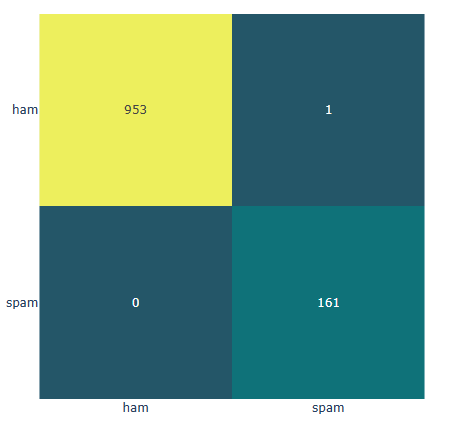

---

## Conclusion

Avec un modèle spécifiquement entrainé pour reconnaitre les spams (mshenoda/roberta-spam), nous arrivons bien à classifier les spams / hams.

Le recall pour les spams atteint 1.00, contre 0.93 pour notre modèle de base, ce qui signifie que 100% des spams sont détectés, contre 7% non détectés auparavant.

C'est intéressant, cependant notre modèle de base offre déjà une performance satisfaisante à moindre coût.

L'utilisation d'un modèle pré-entraîné plus gourmand en ressources se justifie-t-elle ?

Un compromis est donc à envisager entre performance et coût en ressources.